# Brain tumor classification and detection using Keras and LIME


## Preprocess data
First we import all the necessary libraries:

In [1]:
import os
import cv2
import imutils
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
GAUSSIAN_BLUR_SIZE = (5, 5)
THRESHOLD = 20
ERODE_ITERATIONS = 2
DILATE_ITERATIONS = 2
KERNEL = np.ones((3, 3), np.uint8)
EXTRA_SPACE = 0
RESULT_PATH = "./preprocessed_dataset"
SOURCE_PATH = "./brain_tumor_dataset"

Then we define a function used to crop only the brain shape from the MRI:

In [3]:
def crop_image(image_name, result_name):
    img = cv2.imread(image_name)
    greyscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blurred_img = cv2.GaussianBlur(greyscale_img, GAUSSIAN_BLUR_SIZE, 0)
    threshold_img = cv2.threshold(blurred_img, THRESHOLD, 255, cv2.THRESH_BINARY)[1]
    eroded_img = cv2.erode(threshold_img, KERNEL, iterations=ERODE_ITERATIONS)
    dilated_img = cv2.dilate(eroded_img, KERNEL, iterations=DILATE_ITERATIONS)
    contours = cv2.findContours(dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    max_contour = max(contours, key=cv2.contourArea)
    left_point = max(min(max_contour[:, :, 0])[0] - EXTRA_SPACE, 0)
    right_point = min(max(max_contour[:, :, 0])[0] + EXTRA_SPACE, len(img[0]))
    top_point = max(min(max_contour[:, :, 1])[0] - EXTRA_SPACE, 0)
    bottom_point = min(max(max_contour[:, :, 1])[0] + EXTRA_SPACE, len(img))
    result_img = img[top_point:bottom_point, left_point:right_point]
    cv2.imwrite(result_name, result_img)

Now we need to create the result directories and save the cropped pictures there:

In [4]:
if not os.path.exists(f'{RESULT_PATH}'):
    os.makedirs(f'{RESULT_PATH}')
if not os.path.exists(f'{RESULT_PATH}/yes'):
    os.makedirs(f'{RESULT_PATH}/yes')
if not os.path.exists(f'{RESULT_PATH}/no'):
    os.makedirs(f'{RESULT_PATH}/no')

In [5]:
for directory in os.listdir(SOURCE_PATH):
    images = os.listdir(f'{SOURCE_PATH}/{directory}')
    for n, image_name in enumerate(images):
        crop_image(f'{SOURCE_PATH}/{directory}/{image_name}', f'{RESULT_PATH}/{directory}/{str(n)}.jpg')

Let's see how it worked:

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 5, figsize=(15,10))
i = 0
images = os.listdir(f'{RESULT_PATH}/no')
for n, image_name in enumerate(images):
    if n >= 5: 
        break
    img = cv2.imread(f'{RESULT_PATH}/{directory}/{image_name}')
    ax[n].imshow(img)
plt.show()  

<Figure size 1500x1000 with 5 Axes>

## Split the data into subdirectories
Now we create train, validation and test directories with yes/no subdirectories:

In [7]:
if not os.path.exists("train"):
    os.makedirs("train")
    os.makedirs("train/yes")
    os.makedirs("train/no")

if not os.path.exists("test"):
    os.makedirs("test")
    os.makedirs("test/yes")
    os.makedirs("test/no")

if not os.path.exists("validation"):
    os.makedirs("validation")
    os.makedirs("validation/yes")
    os.makedirs("validation/no")

In [8]:
import shutil

for f in os.listdir(RESULT_PATH):
    images = os.listdir(f'{RESULT_PATH}/{f}')
    for n, image in enumerate(images):
        if n < 0.05 * len(images):
            shutil.copy(f'{RESULT_PATH}/{f}/{image}', f'test/{f}/{f + str(n)}.jpg')
        elif n < 0.8 * len(images):
            shutil.copy(f'{RESULT_PATH}/{f}/{image}', f'train/{f}/{f + str(n-round(0.05 * len(images)))}.jpg')
        else:
            shutil.copy(f'{RESULT_PATH}/{f}/{image}', f'validation/{f}/{f + str(n-round(0.8 * len(images)))}.jpg')

## Data augmentation
As we have only 253 images in our dataset we will need to use data augmentation.

In [9]:
from keras.preprocessing.image import ImageDataGenerator

# training data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        'train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=16,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# validation data
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
        'validation',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary')

Using TensorFlow backend.


Found 190 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


## First CNN model
Defining the model architecture:

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))  # filers, kernel size (keras example)
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43264)             0         
__________

Train and save the model:

In [12]:
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // 16,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=800 // 16)

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")




Epoch 1/10





125/125 [==============================] - 71s 569ms/step - loss: 0.7083 - acc: 0.6414 - val_loss: 0.5933 - val_acc: 0.6804
Epoch 2/10
125/125 [==============================] - 65s 523ms/step - loss: 0.5178 - acc: 0.7602 - val_loss: 0.6653 - val_acc: 0.6812
Epoch 3/10
125/125 [==============================] - 67s 538ms/step - loss: 0.3961 - acc: 0.8319 - val_loss: 0.4699 - val_acc: 0.8196
Epoch 4/10
125/125 [==============================] - 70s 560ms/step - loss: 0.3142 - acc: 0.8787 - val_loss: 0.4569 - val_acc: 0.8592
Epoch 5/10
125/125 [==============================] - 67s 537ms/step - loss: 0.2333 - acc: 0.9142 - val_loss: 0.5030 - val_acc: 0.8797
Epoch 6/10
125/125 [==============================] - 65s 520ms/step - loss: 0.1901 - acc: 0.9333 - val_loss: 0.6376 - val_acc: 0.8803
Epoch 7/10
125/125 [==============================] - 66s 530ms/step - loss: 0.1279 - acc: 0.9521 - val_loss: 0.5678 - val_acc: 0.8006
Epoch 8/10
125/125 [===========================

## Model performace:
Model overfits after first epoch

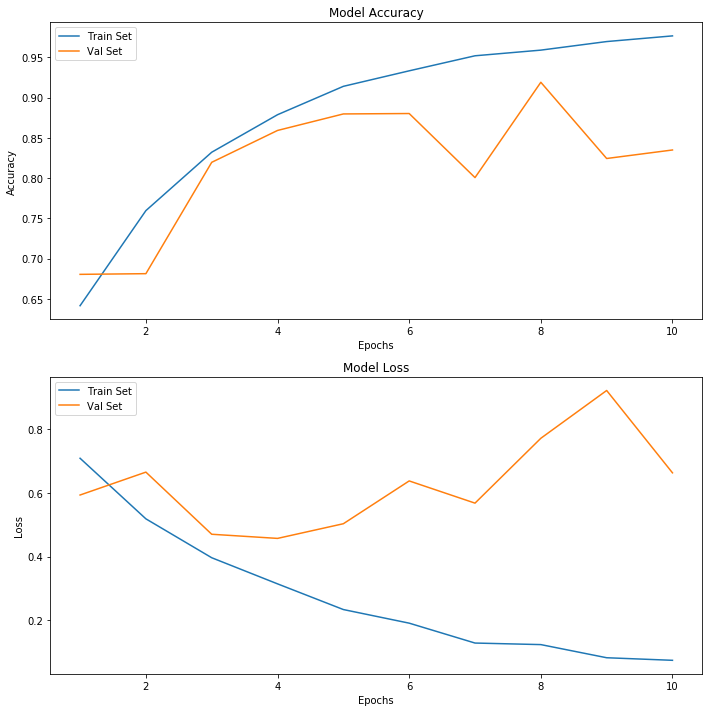

In [13]:
import matplotlib.pyplot as plt
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(1, len(hist.epoch) + 1)

plt.figure(figsize=(10,10))

plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.savefig('plot1', dpi=300)

In [14]:
model.evaluate_generator(test_generator, 100)

[0.3710381644964218, 0.8461538553237915]

## Data simplification
As we're dealing with brain MRI's, we don't need RGB values - we can use gray images.

In [15]:
train_generator = train_datagen.flow_from_directory(
        'train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        color_mode="grayscale",
        batch_size=16,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

validation_generator = validation_datagen.flow_from_directory(
        'validation',
        target_size=(224, 224),
        color_mode="grayscale",
        batch_size=16,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(224, 224),
        color_mode="grayscale",
        batch_size=16,
        class_mode='binary')

Found 190 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


## Second CNN model

In [16]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 1), activation='relu'))  # filers, kernel size (keras example)
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [17]:
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=500 // 16,
        epochs=12,
        validation_data=validation_generator,
        validation_steps=200 // 16)

model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model2.h5")

Epoch 1/12
31/31 [==============================] - 18s 576ms/step - loss: 0.7010 - acc: 0.6063 - val_loss: 0.6656 - val_acc: 0.6200
Epoch 2/12
31/31 [==============================] - 16s 510ms/step - loss: 0.6910 - acc: 0.6025 - val_loss: 0.6672 - val_acc: 0.6400
Epoch 3/12
31/31 [==============================] - 16s 501ms/step - loss: 0.6456 - acc: 0.6313 - val_loss: 0.7588 - val_acc: 0.4400
Epoch 4/12
31/31 [==============================] - 15s 493ms/step - loss: 0.6162 - acc: 0.6711 - val_loss: 0.5882 - val_acc: 0.7200
Epoch 5/12
31/31 [==============================] - 15s 494ms/step - loss: 0.5408 - acc: 0.7319 - val_loss: 0.5551 - val_acc: 0.6600
Epoch 6/12
31/31 [==============================] - 15s 491ms/step - loss: 0.5247 - acc: 0.7657 - val_loss: 0.4926 - val_acc: 0.7400
Epoch 7/12
31/31 [==============================] - 15s 495ms/step - loss: 0.4876 - acc: 0.7777 - val_loss: 0.4762 - val_acc: 0.8000
Epoch 8/12
31/31 [==============================] - 15s 492ms/step - 

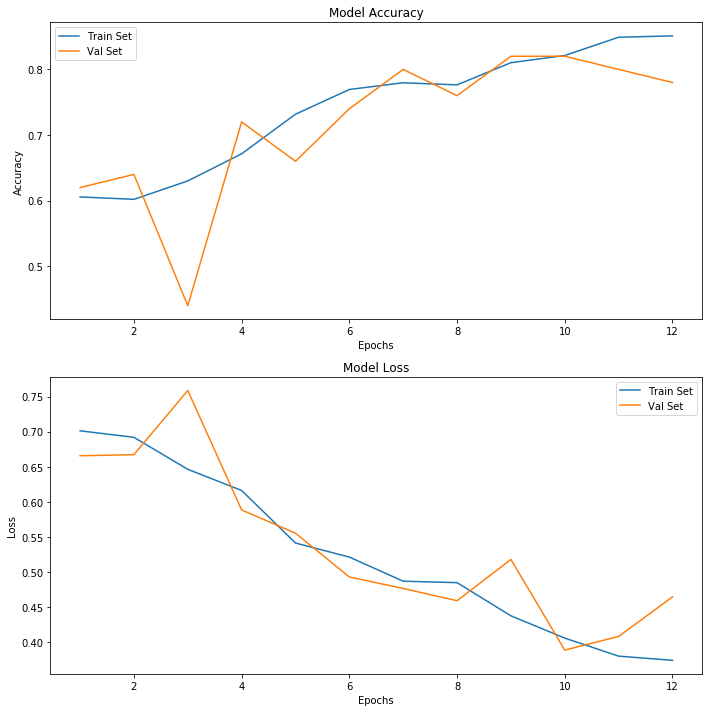

In [18]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(1, len(hist.epoch) + 1)

plt.figure(figsize=(10,10))

plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.savefig('plot2', dpi=300)
plt.show()

In [19]:
model.evaluate_generator(test_generator, 100)

[0.3245190218091011, 0.9230769276618958]

## Different optimizers

In [20]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 1), activation='relu'))  # filers, kernel size (keras example)
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

In [21]:
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=500 // 16,
        epochs=12,
        validation_data=validation_generator,
        validation_steps=200 // 16)

model_json = model.to_json()
with open("model3.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model3.h5")

Epoch 1/12
31/31 [==============================] - 16s 511ms/step - loss: 0.6700 - acc: 0.5980 - val_loss: 0.6680 - val_acc: 0.6267
Epoch 2/12
31/31 [==============================] - 15s 488ms/step - loss: 0.6660 - acc: 0.6152 - val_loss: 0.6685 - val_acc: 0.6133
Epoch 3/12
31/31 [==============================] - 15s 491ms/step - loss: 0.6635 - acc: 0.6155 - val_loss: 0.6619 - val_acc: 0.6267
Epoch 4/12
31/31 [==============================] - 15s 489ms/step - loss: 0.6603 - acc: 0.6114 - val_loss: 0.6669 - val_acc: 0.6133
Epoch 5/12
31/31 [==============================] - 15s 489ms/step - loss: 0.6576 - acc: 0.6112 - val_loss: 0.6572 - val_acc: 0.6200
Epoch 6/12
31/31 [==============================] - 15s 490ms/step - loss: 0.6551 - acc: 0.6086 - val_loss: 0.6521 - val_acc: 0.6267
Epoch 7/12
31/31 [==============================] - 18s 582ms/step - loss: 0.6465 - acc: 0.6086 - val_loss: 0.6547 - val_acc: 0.6200
Epoch 8/12
31/31 [==============================] - 16s 517ms/step - 

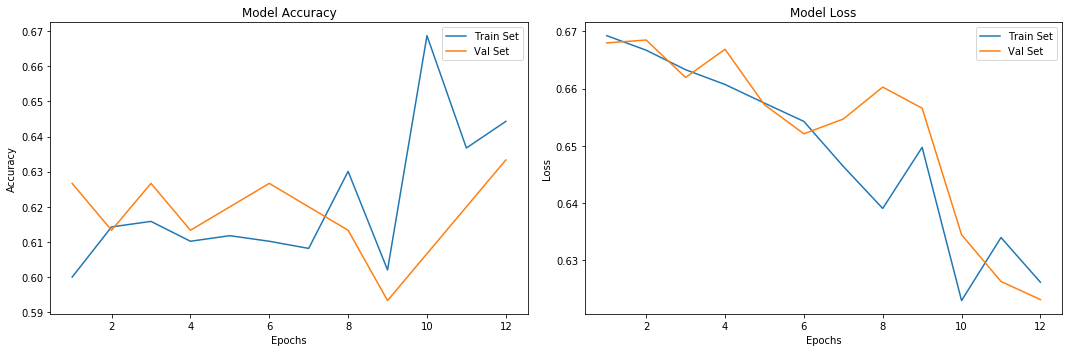

In [22]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(1, len(hist.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [23]:
model.evaluate_generator(test_generator, 100)

[0.6252581393718719, 0.7692307829856873]

SGD - no

In [24]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 1), activation='relu'))  # filers, kernel size (keras example)
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=500 // 16,
        epochs=12,
        validation_data=validation_generator,
        validation_steps=200 // 16)

model_json = model.to_json()
with open("model4.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model4.h5")

Epoch 1/12
31/31 [==============================] - 19s 612ms/step - loss: 0.6920 - acc: 0.5841 - val_loss: 0.6663 - val_acc: 0.6200
Epoch 2/12
31/31 [==============================] - 18s 571ms/step - loss: 0.6605 - acc: 0.6029 - val_loss: 0.6489 - val_acc: 0.6333
Epoch 3/12
31/31 [==============================] - 18s 576ms/step - loss: 0.6395 - acc: 0.6307 - val_loss: 0.5746 - val_acc: 0.8067
Epoch 4/12
31/31 [==============================] - 18s 572ms/step - loss: 0.5773 - acc: 0.7146 - val_loss: 0.5200 - val_acc: 0.8067
Epoch 5/12
31/31 [==============================] - 18s 574ms/step - loss: 0.5231 - acc: 0.7281 - val_loss: 0.4472 - val_acc: 0.8800
Epoch 6/12
31/31 [==============================] - 18s 571ms/step - loss: 0.4659 - acc: 0.7767 - val_loss: 0.4197 - val_acc: 0.7933
Epoch 7/12
31/31 [==============================] - 18s 573ms/step - loss: 0.4339 - acc: 0.8318 - val_loss: 0.3442 - val_acc: 0.8333
Epoch 8/12
31/31 [==============================] - 18s 574ms/step - 

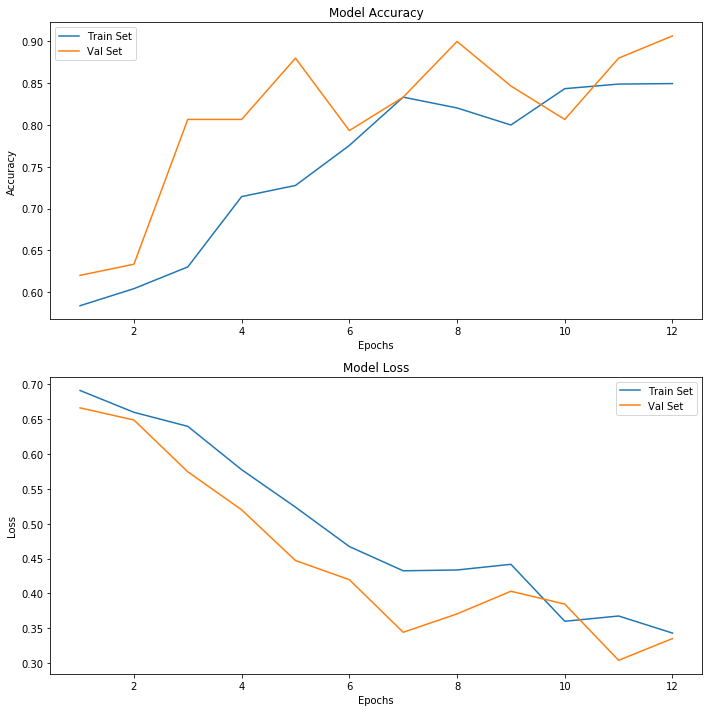

In [26]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(1, len(hist.epoch) + 1)

plt.figure(figsize=(10,10))

plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.savefig('plot4', dpi=300)
plt.show()

In [27]:
model.evaluate_generator(test_generator, 100)

[0.35182045817375185, 0.8461538553237915]

We can load the model with:

In [2]:
from keras.models import model_from_json

json_file = open('model4.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("model4.h5")
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Using TensorFlow backend.







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Explanation 
We start by creating a lime explainer:

In [3]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

C:\Users\Zuza\Anaconda3\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Now we can load a test image and create an explanation for it:

In [4]:
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import rgb_to_grayscale

img = load_img('test/yes/yes0.jpg', target_size=(224, 224))
img = img_to_array(img).astype('double')

def predict_fn(images):
    images = images[:,:,:,:1]
    return model.predict(images)

explanation = explainer.explain_instance(img, predict_fn, top_labels=1, num_samples=1000, hide_color=0)

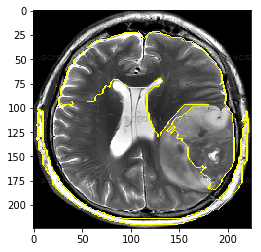

In [20]:
from skimage.segmentation import mark_boundaries
from keras.preprocessing.image import array_to_img
import matplotlib.pyplot as plt

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(array_to_img(temp), mask))
plt.savefig('exp1.png')
plt.show()

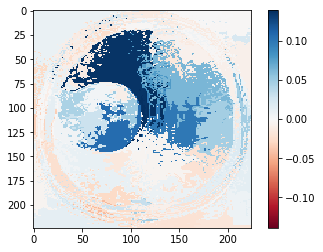

In [11]:
import numpy as np
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.savefig('explanation.png')
plt.show()

### Segmentation function

Felzenszwalb number of segments: 254
SLIC number of segments: 50
Quickshift number of segments: 12611


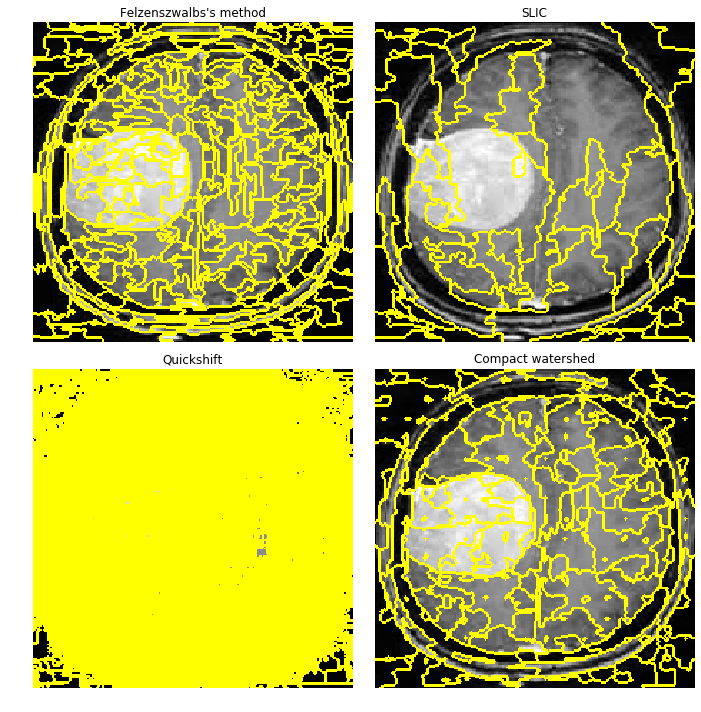

In [13]:
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel
from skimage.color import rgb2gray

img = load_img('test/yes/yes0.jpg', target_size=(224, 224))
img = img_to_array(img).astype('double')

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1,
                     start_label=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)
print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")
print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

img = array_to_img(img)
ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.savefig('segmentations.png')
plt.show()

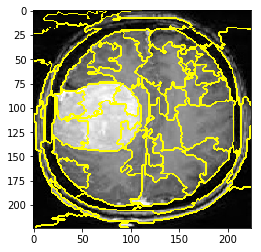

In [34]:
img = load_img('test/yes/yes0.jpg', target_size=(224, 224))
img = img_to_array(img).astype('double')

segments_fz = felzenszwalb(img, scale=100, sigma=0.1, min_size=200)
plt.imshow(mark_boundaries(array_to_img(img), segments_fz))

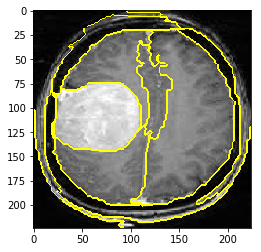

In [35]:
img = load_img('test/yes/yes0.jpg', target_size=(224, 224))
img = img_to_array(img).astype('double')

segments_fz = felzenszwalb(img, scale=100, sigma=0.9, min_size=1200)
plt.imshow(mark_boundaries(array_to_img(img), segments_fz))

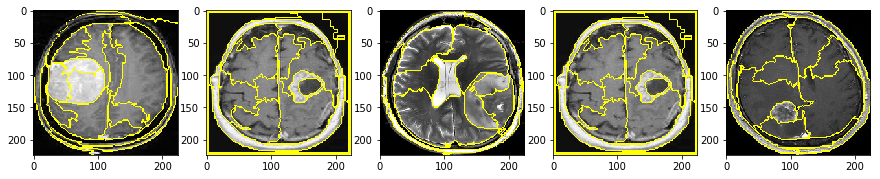

In [14]:
fig, ax = plt.subplots(1, 5, figsize=(15,10))
for i in range(5):
    img = load_img(f'test/yes/yes{i}.jpg', target_size=(224, 224))
    img = img_to_array(img).astype('double')
    segments_fz = felzenszwalb(img, scale=100, sigma=0.9, min_size=500)
    ax[i].imshow(mark_boundaries(array_to_img(img), segments_fz))
plt.savefig('explanation.png', dpi=300)
plt.show()  

In [15]:
def segmentation_fn(img):
    segments_fz = felzenszwalb(img, scale=100, sigma=0.9, min_size=500)
    return segments_fz

In [16]:
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import rgb_to_grayscale

img = load_img('test/yes/yes2.jpg', target_size=(224, 224))
img = img_to_array(img).astype('double')

def predict_fn(images):
    images = images[:,:,:,:1]
    return model.predict(images)

explanation = explainer.explain_instance(img, predict_fn, top_labels=1, num_samples=1000, hide_color=0, segmentation_fn=segmentation_fn)

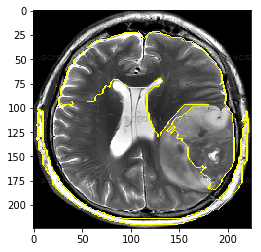

In [19]:
from skimage.segmentation import mark_boundaries
from keras.preprocessing.image import array_to_img

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(array_to_img(temp), mask))
plt.savefig('exp2.png')
plt.show()

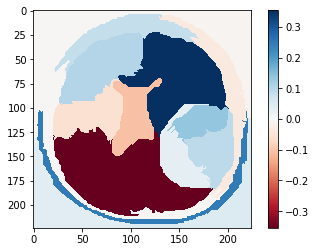

In [18]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.savefig('explanation2.png')
plt.show()